<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
#установка библиотек
!pip install catboost

In [ ]:
#импорт библиотек
import os

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

In [ ]:
#загрузка данных
pth1 = 'taxi.csv'
pth2 = 'C:\projects\time_series\taxi.csv'

if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, index_col=['datetime'], parse_dates=['datetime'])
elif os.path.exists(pth2):
    taxi = pd.read_csv(pth2, index_col=['datetime'], parse_dates=['datetime'])
else:
    print('Something is wrong')

In [ ]:
#вывод основной информации о датафрейме
dfdict = {
    'taxi': taxi
}

def dfinf(df):
    print(f'Название датафрейма: {df}\n')
    dfdict[df].info()
    display(dfdict[df].head())

_ = list(map(dfinf, dfdict))

Название датафрейма: taxi

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
#убедимся в монотонности временного ряда
taxi.index.is_monotonic_increasing

True

In [ ]:
#выполним ресемплирование по 1 часу
taxi = taxi.resample('1H').sum()

**Загрузка и предобработка данных**<br>
*Датасет `autos.csv`* содержит данные о периодах времени (`datetime`, данные взяты через каждые 10 минут) и количестве заказов за этот период (`num_orders`). Колонка `datetime` переведена в тип данных `datetime` и назначена в качестве индекса. Выполнена проверка на монотонность временного ряда и сделано ресемплирование с периодом `1H`.

## Анализ

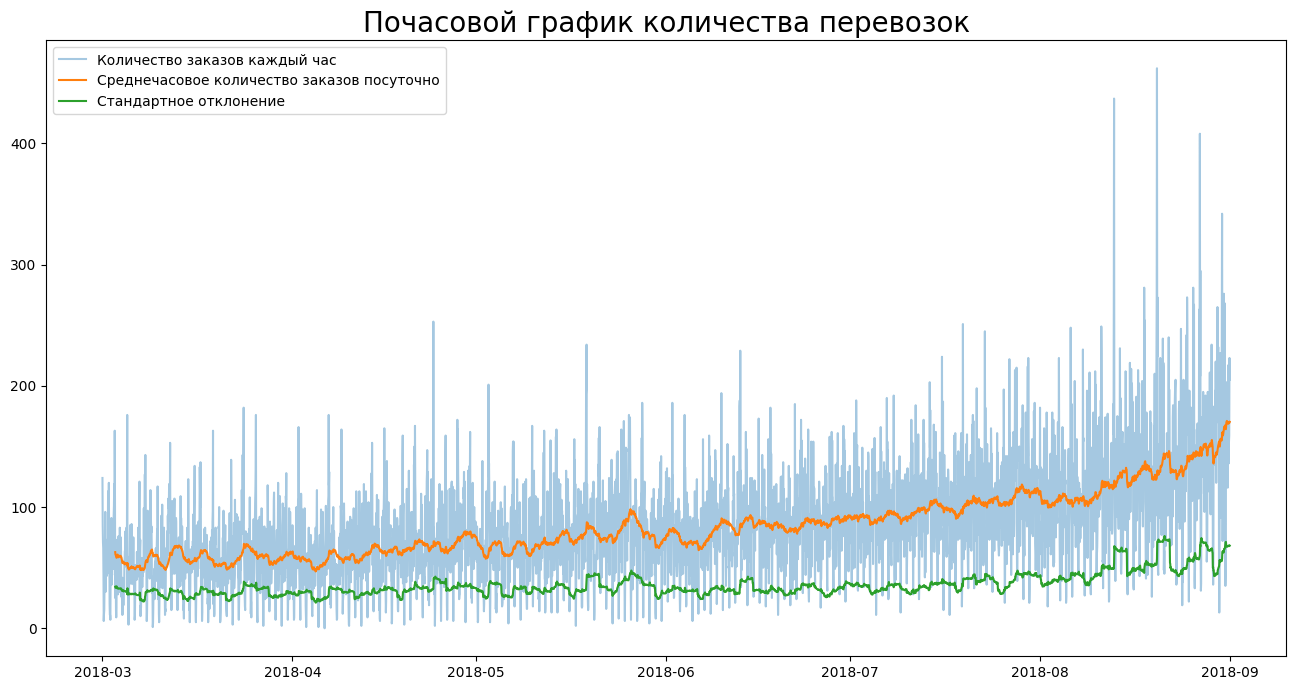

In [ ]:
#построим графики
plt.figure(figsize=(16, 8))
plt.plot(taxi, alpha=0.4)
plt.plot(taxi.shift().rolling(50).mean())
plt.plot(taxi.shift().rolling(50).std())
plt.legend(['Количество заказов каждый час',
            'Среднечасовое количество заказов посуточно',
            'Стандартное отклонение'],
           fontsize=10,
           loc='upper left')
plt.title('Почасовой график количества перевозок', fontsize=20);

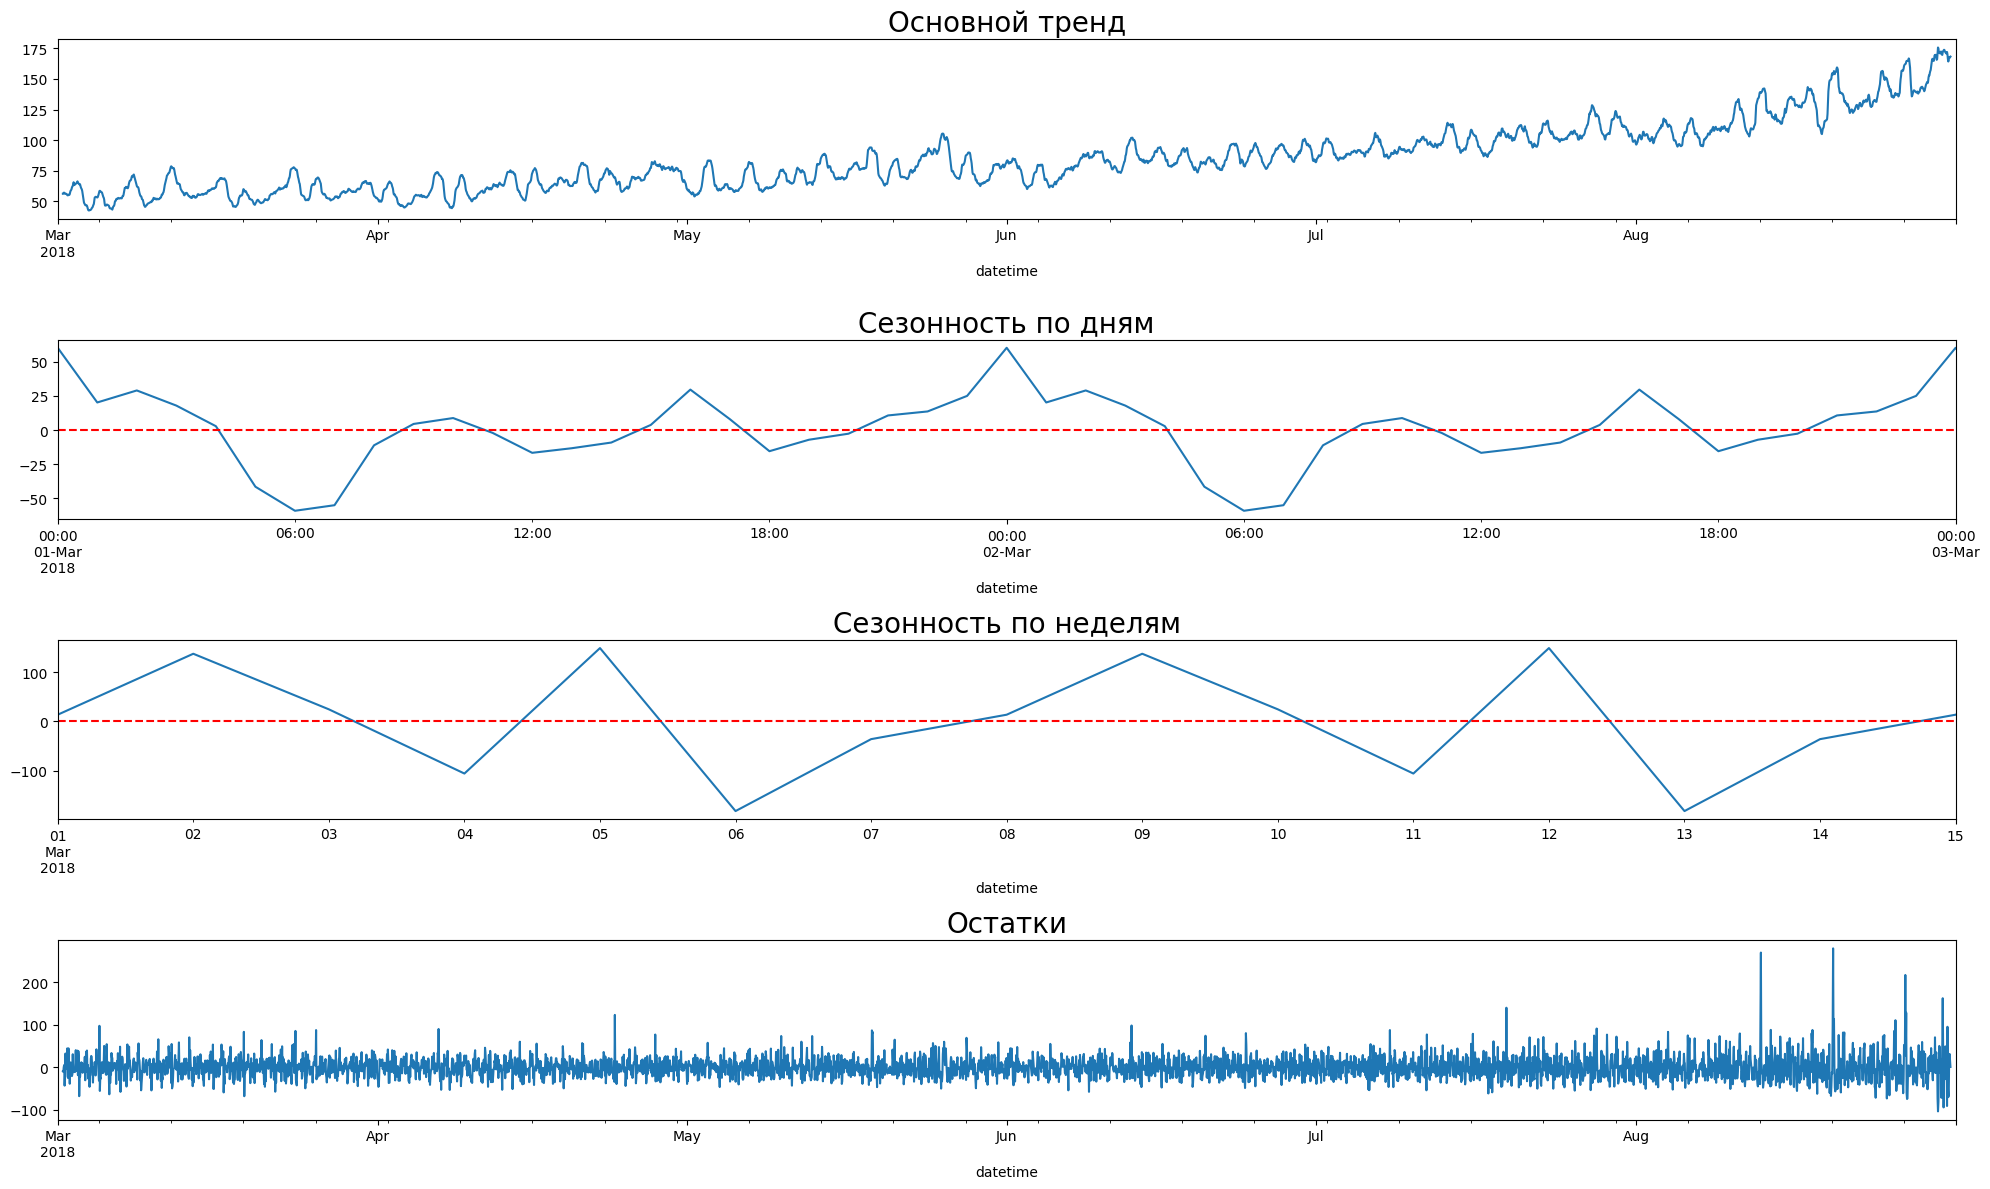

In [ ]:
#узнаем тренды и сезонность
decomposed = seasonal_decompose(taxi)

taxi_day = taxi.resample('1D').sum()
decomposed_day = seasonal_decompose(taxi_day)

plt.figure(figsize=(20, 12))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Основной тренд', fontsize=20)
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность по дням', fontsize=20)
plt.xlim('2018-03-01', '2018-03-03')
plt.axhline (y=0, color='red', linestyle='--')
plt.subplot(413)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность по неделям', fontsize=20)
plt.xlim('2018-03-01', '2018-03-15')
plt.axhline (y=0, color='red', linestyle='--')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки', fontsize=20)
plt.tight_layout()

**Анализ временного ряда**<br>
По графикам видно, что среднечасовое значение поездок в период с марта по август включительно 2018 года *выросло с около 60 заказов в час до 160*. Прослеживается тренд на *ежемесячный рост поездок* - особенно ярко этот рост выражен в *летние месяцы* из-за ускорения тренда. В августе заметны большие колебания в почасовых заказах, что отражено в повышенном стандартном отклонении на протяжении практически всего месяца. Поэтому хоть и в общем заказов в августе больше, чем в другие месяцы, могут быть просадки. <br>
В течение дня пик поездок наблюдается в *полночь*, тогда как наименьшее количество заказов - *в 6 часов утра*. По дням недели пики наблюдаются во *вторник и пятницу*, а спады - в *субботу и четверг*. Пятничный и субботний тренд были предполагаемы - люди в последний день недели хотят или быстрее попасть домой после работы, или добраться до каких либо развлечений (бары, театры, концерты), а в субботу отдыхают дома или вне города, тем самым уменьшая количество заказов.<br>
В августе можно наблюдать значительные всплески поездок - имеются часы, в которые было совершено более 300 и даже 400 поездок. Данное увеличение отражается и на графике остатков - во второй половине августа наблюдается наибольшее их значение, причем размер остатков сильно превосходит предыдущие, что при условии тестовой выборки размером 10% от временного ряда может привести к значительной разнице в метриках на тренировочной и тестовой выборке.

## Обучение

In [ ]:
#добавим признаки
def make_features(data, max_lag, rolling_mean_size):
    data_feat = data
    data_feat['dayofweek'] = data_feat.index.dayofweek
    data_feat['hour'] = data_feat.index.hour

    for lag in range(1, max_lag + 1):
        data_feat['lag_{}'.format(lag)] = data_feat['num_orders'].shift(lag)

    data_feat['rolling_mean'] = data_feat['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_feat.dropna()


taxi_feat = make_features(taxi, 3, 6)

In [ ]:
#выполним сплитование
RANDOM_STATE = 12345

features_train, features_test, target_train, target_test = train_test_split(
    taxi_feat.drop(columns='num_orders'),
    taxi_feat.num_orders,
    shuffle=False,
    test_size=0.1,
    random_state=RANDOM_STATE)

In [ ]:
#простейшие модели без обучения - константа и предыдущее значение
print('Средний объём заказов по часам:', target_test.mean())

pred_median = np.ones(target_test.shape) * target_train.median()
print('RMSE для медианного значения:', mean_squared_error(target_test, pred_median, squared=False))

pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print("RMSE для предыдущего значения:", mean_squared_error(target_test, pred_previous, squared=False))

Средний объём заказов по часам: 139.64172335600907
RMSE для медианного значения: 87.24205906985632
RMSE для предыдущего значения: 58.91761802963282


In [ ]:
#обучим linearRegression
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
pred_lr = model_lr.predict(features_train)
rmse_lr = mean_squared_error(target_train, pred_lr, squared=False)

In [ ]:
#создадим вспомогательную функцию
def rscv (model, parameters):
    tscv = TimeSeriesSplit(n_splits=3)
    rs = RandomizedSearchCV(
        model,
        parameters,
        n_jobs=-1,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE
    )

    rs.fit(features_train, target_train)

    rmse_best = -rs.best_score_

    model_best = rs.best_estimator_
    return rmse_best, model_best

In [ ]:
#инициализируем модель DecisionTreeRegressor и подберем гиперпараметры с помощью RandomizedSearchCV
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters_dtr = {
    'min_samples_leaf': range(2, 200),
    'max_depth': range(2, 200)
}

rmse_dtr, model_dtr = rscv(model_dtr, parameters_dtr)

In [ ]:
#инициализируем модель LGBMRegressor и подберем гиперпараметры с помощью RandomizedSearchCV
model_lgb = LGBMRegressor(learning_rate=1, random_state=RANDOM_STATE)

parameters_lgb = {
    'num_leaves': range(2, 20),
    'max_depth': range(2, 20)
}

rmse_lgb, model_lgb = rscv(model_lgb, parameters_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 6
[LightGBM] [Info] Start training from score 78.315445


In [ ]:
#инициализируем модель CatBoostRegressor и подберем гиперпараметры с помощью RandomizedSearchCV
model_cat = CatBoostRegressor(learning_rate=1, verbose=False, random_state=RANDOM_STATE)

parameters_cat = {
    'min_data_in_leaf': range(2, 10),
    'max_depth': range(2, 10)
}

rmse_cat, model_cat = rscv(model_cat, parameters_cat)

**Обучение моделей**<br>
Для обучения моделей предсказания количества поездок на следующий час были добавлены признаки `month`, `day`, `dayofweek` и `hour`, а также несколько признаков, содержащих значения следующих часов (количество можно определять самостоятельно с помощью параметра `max_lag` в функции `make_features`).<br>
В качестве моделей для сравнения были выбраны *четыре основных модели* - **LGBMRegressor, CatBoostRegressor, LinearRegression и DecisionTreeRegressor**. Определение оптимальных *гиперпараметров* проводилось посредством **RandomizedSearchCV**. Также для сравнения рассматривались *константная модель с медианным значением тренировочной выборки* и *модель, прогнозирующая следующее значение по предыдущему*.

## Тестирование

In [ ]:
#соберем таблицу с rmse
comp_df = pd.DataFrame([[rmse_lr],
                        [rmse_dtr],
                        [rmse_lgb],
                        [rmse_cat]],
                       columns=['rmse'],
                       index=['lr', 'DTR', 'LGB', 'Cat'])

comp_df.round(3).sort_values('rmse')

,rmse
LGB,29.656
DTR,31.466
lr,31.617
Cat,32.469


In [ ]:
#определим rmse лучшей модели на тестовой выборке
best_predict = model_lgb.predict(features_test)
rmse_best_model = mean_squared_error(target_test, best_predict, squared=False)
print('RMSE для лучшей модели на тестовых данных:', round(rmse_best_model, 3))

RMSE для лучшей модели на тестовых данных: 47.43


**Сравнение моделей**<br>
При обучении моделей были получены значения `RMSE` для тренировочных выборок. Значения метрики всех рассматриваемых моделей лучше, чем у константной модели и модели предыдущего значения.  Наилучший результат по `RMSE` продемонстрировала **LGBMRegressor**. Расчет требуемой метрики на тестовой выборке показал результат **47.43**, что ниже установленной планки в **48**. Значительная разница в метриках тренировочной и тестовой выборки обусловлена большими остатками - подобный исход предполагался выше при анализе данных из-за концентрации наибольших значений остатков на правом конце рассматриваемого временного ряда.